In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
%matplotlib inline

In [83]:
#Set our hyperparameters 
batch_size = 64
number_classes = 10
lrate = 0.0005
number_epochs = 30

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #GPU vs CPU for running

In [86]:
!pip install torch torchvision torchaudio

In [87]:
torch.manual_seed(73)

In [ ]:
#Download the Dataset
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
data_normalization = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize(mean=[0.567, 0.3211, 0.4332], std=[0.1443, 0.18776, 0.2982]) ])
# Create Training dataset
train_data = torchvision.datasets.CIFAR10(root = './data',train = True, transform = data_normalization,download = True)

# Create Testing dataset
test_data = torchvision.datasets.CIFAR10(root = './data', train = False,transform = data_normalization,  download=True)

# Instantiate loader objects to facilitate processing
train_loader = torch.utils.data.DataLoader(dataset = train_data,  batch_size = batch_size,  shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,batch_size = batch_size, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Explore Dataset Size and classes
print("Training Data Size:",len(training_data))
print("Test Data Size:",len(test_data))
classes = training_data.classes
classes

Training Data Size: 50000
Test Data Size: 10000


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

60,0000 images total, 50,000 images in train set (5000 per class for 10 classes), and 10,000 test images. Each image is 32x32x3.

Image Shape: torch.Size([3, 32, 32])
Label: deer


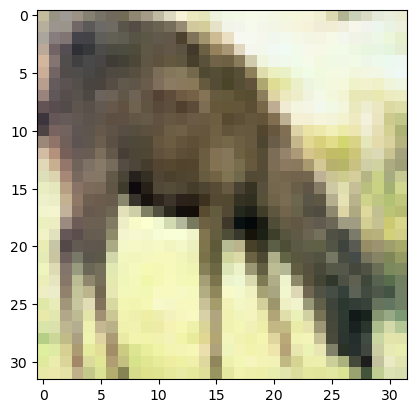

In [ ]:
#Look at one image
im, label = train_data[500]
shape = im.shape
print("Image Shape:",shape)
print("Label:",classes[label])
plt.imshow(im.permute((1, 2, 0)))

In [ ]:
#Validation Set Extraction
size=5000
validation_size = size
train_size_prev=len(train_data)
train_size = train_size_prev - validation_size
train_data, validation_data = random_split(train_data, [train_size, validation_size])
print("Number of Images in Training Data:",len(train_data))
print("Number of Images in Test Data:",len(validation_data))

Number of Images in Training Data: 40000
Number of Images in Test Data: 5000


Basic CNN Setup

In [ ]:
# Create a class that extends the nn.Module from pytorch 
class CNN(nn.Module):
	#  Build our CNN Architecture by specifying the convolution,max pooling and non linearity layers
    def __init__(self, number_classes):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(3,32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(32,32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(64, 64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU() #Use ReLU for our activation function
        self.fc2 = nn.Linear(128, number_classes)
    
    # Define order of how data is forward fed into the neural network   
    def forward(self, input):
        out = self.conv_layer1(input)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)
        final_shape=out.size(0)       
        out = out.reshape(final_shape, -1) #Reshape so that data can be fed into fully connected layer
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [ ]:
#Hyperparameter Setup for Neural Network
iterations = len(train_loader) #Number of Iterations in through our batches
conv_net = CNN(number_classes)
loss_function = nn.CrossEntropyLoss() #Use cross entropy loss because we are doing a classification class and using ReLU activation
back_prop_opt = torch.optim.SGD(conv_net.parameters(), lr=lrate, weight_decay = 0.0001, momentum = 0.9) #Use Stochastic Gradient Descent for optimizer function

In [ ]:
#Train our Convolutional Neural Network

for ep in range(number_epochs): #Loop through epoch numbers
    for j, (imgs, classes) in enumerate(train_loader): #Loop through the batches 
        #Define if using GPU or CPU
        imgs = imgs.to(device)
        classes = classes.to(device)
        
        # Pass the data through the Forward pass
        out = conv_net(imgs)
        loss_value = loss_function(out, classes) #Calculate the loss based on the forward pass
        
        # Do Backproprogation using SGD to update weights based on loss
        back_prop_opt.zero_grad() #Set gradient to zero before each weight update
        loss_value.backward() #Find value of new gradients based on current loss value
        back_prop_opt.step() #Compute new weights on our optimizer using the new gradients

    print('Epoch [{}/{}], Loss: {:.4f}'.format(ep+1, number_epochs, loss_value.item()))          

Epoch [1/30], Loss: 1.6949
Epoch [2/30], Loss: 1.7142
Epoch [3/30], Loss: 1.5293
Epoch [4/30], Loss: 1.4770
Epoch [5/30], Loss: 1.2829
Epoch [6/30], Loss: 1.0998
Epoch [7/30], Loss: 1.0465
Epoch [8/30], Loss: 1.1742
Epoch [9/30], Loss: 1.5001
Epoch [10/30], Loss: 0.8627
Epoch [11/30], Loss: 1.1475
Epoch [12/30], Loss: 1.0420
Epoch [13/30], Loss: 0.7186
Epoch [14/30], Loss: 1.3537
Epoch [15/30], Loss: 0.8709
Epoch [16/30], Loss: 0.7314
Epoch [17/30], Loss: 0.6417
Epoch [18/30], Loss: 0.6580
Epoch [19/30], Loss: 0.7468
Epoch [20/30], Loss: 0.9458
Epoch [21/30], Loss: 0.6189
Epoch [22/30], Loss: 0.8392
Epoch [23/30], Loss: 0.7328
Epoch [24/30], Loss: 0.5314
Epoch [25/30], Loss: 0.7739
Epoch [26/30], Loss: 0.5934
Epoch [27/30], Loss: 0.5068
Epoch [28/30], Loss: 0.5527
Epoch [29/30], Loss: 0.8109
Epoch [30/30], Loss: 0.4304


In [ ]:
#Testing our Convolutional Neural Network

#Training Accuracy
with torch.no_grad():
    accur = 0
    sample=0
    for imgs, classes in train_loader:
        imgs = imgs.to(device)
        classes = classes.to(device)
        out = conv_net(imgs)
        _, class_hat = torch.max(out.data, 1)
        accur += (class_hat == classes).sum().item()
        sample += classes.size(0)
    
    print("Training Accuracy:",(100 * accur / sample))

#Testing Accuracy
with torch.no_grad():
    accur = 0
    sample=0
    for imgs, classes in test_loader:
        imgs = imgs.to(device)
        classes = classes.to(device)
        out = conv_net(imgs)
        _, class_hat = torch.max(out.data, 1)
        accur += (class_hat == classes).sum().item()
        sample += classes.size(0)
    
    print("Testing Accuracy:",(100 * accur / sample))

Training Accuracy: 86.818
Testing Accuracy: 67.7


AlexNet Implementation

In [88]:
#Set our hyperparameters 
batch_size = 256
number_classes = 10
lrate = 0.01
number_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #GPU vs CPU for running
torch.manual_seed(73)

In [101]:
#Data Transforms, Loaders and Visualizing data
data_normalization = transforms.Compose([transforms.Resize((70,70)),transforms.ToTensor(),transforms.CenterCrop((64, 64)),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ])
# Training dataset
train_data = torchvision.datasets.CIFAR10(root = './data',train = True, transform = data_normalization,download = True)

# Testing dataset
test_data = torchvision.datasets.CIFAR10(root = './data', train = False,transform = data_normalization,  download=True)

#Loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,  batch_size = batch_size,  shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,batch_size = batch_size, shuffle = True)

# Checking the dataset
for imgs, labels in train_loader:  
    #Print One Sample
    print("Dimensions of Images in Each Batch:", imgs.shape)
    print("Label Shapes:", labels.shape)
    break

Files already downloaded and verified
Files already downloaded and verified
Dimensions of Images in Each Batch: torch.Size([256, 3, 64, 64])
Label Shapes: torch.Size([256])


In [90]:
class AlexNet(torch.nn.Module):

    def __init__(self, class_numbers):
        super().__init__()
        #Define the standard convolution,ReLU and max pooling layers of the AlexNet Architecture
        self.feature_extraction = torch.nn.Sequential(
            torch.nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            torch.nn.ReLU(inplace=True), #Using ReLU as activation function
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(256, 256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.pool_average = torch.nn.AdaptiveAvgPool2d((6, 6))
        #Define the fully connected layers at the end of AlexNet
        self.predictions = torch.nn.Sequential(
            torch.nn.Linear(256 * 6 * 6, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=0.5,inplace=False),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, class_numbers)
        )
    # Define order of how data is forward fed into the neural network   
    def forward(self, input):
        out = self.feature_extraction(input) #Run input into feature extraction layer(conv,ReLu and Maxpool)
        out = self.pool_average(out) #Perform average max pooling
        out = out.view(out.size(0), 256 * 6 * 6) #Reshape so that data can be fed into fully connected layer
        final_out = self.predictions(out) #Get final classification predictions from fully connected layers
        return final_out

The above architecture was adopted from the following github page: https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L13/code/2-alexnet-cifar10.ipynb

In [91]:
#Hyperparameter Setup for Neural Network
iterations = len(train_loader) #Number of Iterations in our batches
alex_net = AlexNet(number_classes)
loss_function = nn.CrossEntropyLoss() #Use cross entropy loss because we are doing a classification class and using ReLU activation
bp_optimizer = torch.optim.SGD(alex_net.parameters(), lr=lrate, momentum = 0.9) #Use Stochastic Gradient Descent for optimizer function

On Epoch [1/50], Current Loss Value: 2.2962
On Epoch [2/50], Current Loss Value: 2.0054
On Epoch [3/50], Current Loss Value: 1.7132
On Epoch [4/50], Current Loss Value: 1.6618
On Epoch [5/50], Current Loss Value: 1.3911
On Epoch [6/50], Current Loss Value: 1.2908
On Epoch [7/50], Current Loss Value: 0.8591
On Epoch [8/50], Current Loss Value: 0.7709
On Epoch [9/50], Current Loss Value: 0.8368
On Epoch [10/50], Current Loss Value: 0.5930
On Epoch [11/50], Current Loss Value: 0.6815
On Epoch [12/50], Current Loss Value: 0.5569
On Epoch [13/50], Current Loss Value: 0.8003
On Epoch [14/50], Current Loss Value: 0.6707
On Epoch [15/50], Current Loss Value: 0.4434
On Epoch [16/50], Current Loss Value: 0.4307
On Epoch [17/50], Current Loss Value: 0.3325
On Epoch [18/50], Current Loss Value: 0.2828
On Epoch [19/50], Current Loss Value: 0.1788
On Epoch [20/50], Current Loss Value: 0.1648
On Epoch [21/50], Current Loss Value: 0.1462
On Epoch [22/50], Current Loss Value: 0.0594
On Epoch [23/50], C

Text(0, 0.5, 'Training Error')

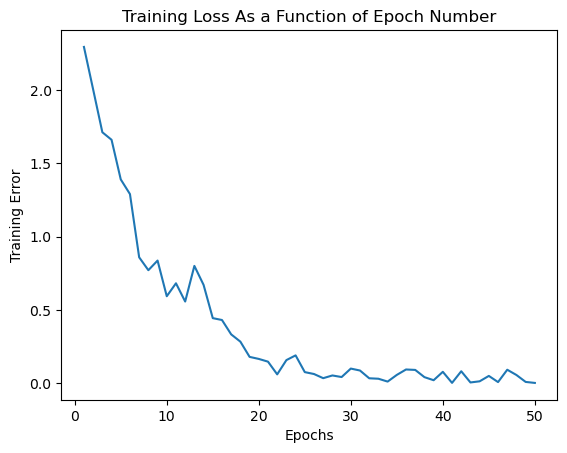

In [92]:
#Train AlexNet
loss_store=np.zeros(number_epochs)
for ep in range(number_epochs): #Loop through epoch numbers
    for j, (imgs, classes) in enumerate(train_loader): #Loop through the batches 
        #Define if using GPU or CPU
        imgs = imgs.to(device)
        classes = classes.to(device)
        
        # Pass the data through the Forward pass
        out = alex_net(imgs)
        loss_value = loss_function(out, classes) #Calculate the loss based on the forward pass
        
        # Do Backproprogation using SGD to update weights based on loss
        bp_optimizer.zero_grad() #Set gradient to zero before each weight update
        loss_value.backward() #Find value of new gradients based on current loss value
        bp_optimizer.step() #Compute new weights on our optimizer using the new gradients
    loss_store[ep]=loss_value.item()
    print('On Epoch [{}/{}], Current Loss Value: {:.4f}'.format(ep+1, number_epochs, loss_value.item())) 

#Plot Training Error as a function of Epoch
plt.plot(np.arange(1,number_epochs+1,1),loss_store)
plt.title("Training Loss As a Function of Epoch Number")
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [93]:
#Testing AlexNet

#Training Accuracy
with torch.no_grad():
    accur = 0
    sample=0
    for imgs, classes in train_loader:
        classes = classes.to(device)
        imgs = imgs.to(device)
        out = alex_net(imgs)
        na, class_hat = torch.max(out.data, 1)
        accur += (class_hat == classes).sum().item()
        sample += classes.size(0)
    
    print("Training Accuracy:",(100 * accur / sample))

#Testing Accuracy
with torch.no_grad():
    accur = 0
    sample=0
    for imgs, classes in test_loader:
        classes = classes.to(device)
        imgs = imgs.to(device)
        out = alex_net(imgs)
        na, class_hat = torch.max(out.data, 1)
        accur += (class_hat == classes).sum().item()
        sample += classes.size(0)
    
    print("Testing Accuracy:",(100 * accur / sample))

Training Accuracy: 99.734
Testing Accuracy: 74.76


Attacking the Network

1: Fast Gradient Signed Method Attack(Untargetted)

In [5]:
#Reload data with batch size=1 for FGSM only
test_loader = torch.utils.data.DataLoader(dataset = test_data,batch_size = 1, shuffle = True) 
eps = 0.1

def FGSM(img,gradient,e):
    signs = gradient.sign() #Extract the gradient signs
    # Create the perturbed image by adjusting each pixel of the input image
    x_perturb = img + e*signs #Create our perturbered image by adding a small epsilon in the direction of the gradient
    image_attack = torch.clamp(x_perturb, 0, 1) #Clamp the image pixel value to make sure its an image
    return image_attack #Return our final attacked image

def attack_network(dev,loader,e,number):
    accur = []
    sample=0
    iter=0
    for imgs, classes in loader:
        print("On Iteration ",iter )
        classes = classes.to(dev)
        imgs = imgs.to(dev)
        imgs.requires_grad=True
        out = alex_net(imgs)
        class_hat = out.max(1, keepdim=True)[1] #Initial Label Prediction
        #Attack the network only if it already predicts the image class correctly
        if classes.item()==class_hat.item(): 
            #Calculate the current value of the loss
            loss_value = loss_function(out, classes) 
            # Do Backproprogation using SGD to update weights based on loss
            bp_optimizer.zero_grad() #Set gradient to zero before each weight update
            loss_value.backward() #Find value of new gradients based on current loss value
            gradients = imgs.grad.data #Get current gradients
            #Attack the network using FGSM
            img_attack=FGSM(imgs,gradients,e)
            class_hat_attack=alex_net(img_attack) #Get new network prediction with attack
            attack_pred = class_hat_attack.data.max(1, keepdim=True)[1]#Initial Prediction
            if attack_pred.item()==classes.item():
                accur.append(1)
        sample += classes.size(0)
        iter+=1
    accur=np.array(accur)
    ac_total=(100 * np.sum(accur) / sample)
    print(ac_total.shape)
    print("Accuracy for Epsilon ={}".format(e,ac_total)) #Observe how accuracy is changing with FGSM attack
    return ac_total
accur_store=attack_network(device,test_loader,eps,1)


Reported Accuracy 5.54%.

#2: Projected Gradient Descent (PGD)
    Note: PGD is similar to Iterative-IFGSM
    Note:We will use PGD attack from the torchattacks library
        -Reference can be found here: https://github.com/Harry24k/adversarial-attacks-pytorch
        Citation:
        @article{kim2020torchattacks,
        title={Torchattacks: A pytorch repository for adversarial attacks},
        author={Kim, Hoki},
        journal={arXiv preprint arXiv:2010.01950},
        year={2020}
        }

In [95]:
!pip install torchattacks

In [111]:
import torchattacks
from torchattacks import PGD

In [97]:
#Note: This function was copied from the utils.py file from the torchattacks repository cited above
def get_pred(model, images, device):
    logits = model(images.to(device))
    _, pres = logits.max(dim=1)
    return pres.cpu()

In [106]:
test_loader = torch.utils.data.DataLoader(dataset = test_data,batch_size = batch_size, shuffle = True)

atck_net = PGD(alex_net, eps=8/255, alpha=2/225, steps=10, random_start=True)
ac=0
sample=0
count=0
for imgs,classes in test_loader:
    imgs_attack=atck_net(imgs, classes)
    prediction=get_pred(alex_net, imgs_attack, device)
    for j in range(prediction.shape[0]):
        if prediction[j]==classes[j]:
            ac+=1
    sample += classes.size(0)
    count+=1

accur= 100*np.sum(ac)/sample
print("PGD Attack Testing Accuracy:",accur)

PGD Attack Testing Accuracy: 5.54


We can see that we can drop the testing accuracy with PGD attacks to 5.54% if we attack every image in the network that was not initially classified miscorrectly. 

Text(0.5, 1.0, 'Example of PGD Attack Image')

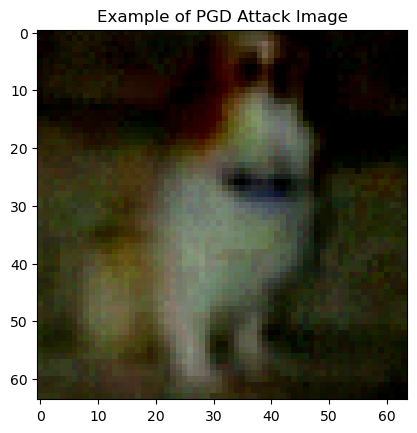

In [121]:
plt.imshow(imgs_attack[3].permute((1, 2, 0)))
plt.title("Example of PGD Attack Image")